# Imports

In [1]:
import wandb
from wandb.integration.keras import WandbCallback
wandb.login()

2024-06-10 10:15:32.909136: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.
wandb: Currently logged in as: alvaro-francisco-gil (orbit-generation). Use `wandb login --relogin` to force relogin


True

In [2]:
import tensorflow as tf

# List available physical devices
gpus = tf.config.list_physical_devices('GPU')
print(f"GPUs found: {len(gpus)}")

# Print GPU details
for i, gpu in enumerate(gpus):
    print(f"GPU {i}: {gpu}")

# Assuming 'GPU:1' is the identifier for the second GPU
gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        # Disable first GPU
        tf.config.set_visible_devices(gpus[1], 'GPU')
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print("Logical GPUs:", logical_gpus)
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)



GPUs found: 3
GPU 0: PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
GPU 1: PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')
GPU 2: PhysicalDevice(name='/physical_device:GPU:2', device_type='GPU')
Logical GPUs: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]


2024-06-10 10:15:36.562843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-10 10:15:37.313675: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1532] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22308 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:1c:00.0, compute capability: 8.6


In [3]:
from orbit_generation.visualize import export_dynamic_orbits_html, visualize_static_orbits
from orbit_generation.stats import plot_histograms_comparison, plot_latent_space, plot_combined_latent_space
from orbit_generation.dataset import get_first_period_fixed_step_dataset, get_orbit_classes
from orbit_generation.model import get_optimizer
from orbit_generation.propagation import calculate_errors
from orbit_generation.experiment import setup_new_experiment

/usr/local/lib/python3.8/dist-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [4]:
%load_ext autoreload
%autoreload 2

import numpy as np
from tensorflow import keras
import tsgm
import os

2024-06-10 10:15:45.802851: I tensorflow/stream_executor/cuda/cuda_blas.cc:1786] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2024-06-10 10:15:45.805692: I tensorflow/core/util/cuda_solvers.cc:179] Creating GpuSolver handles for stream 0x6dbced0


# Parameters

In [6]:
data_path = r"/orbit-generation/data/orbits_dt_0_01/EM_dt_fix_0_01.h5"
experiments_folder = "../experiments"

In [7]:
params = {
    'model_name': 'vae_conv5',
    'data_used': os.path.splitext(os.path.basename(data_path))[0],
    'latent_dim': 32,
    'feature_dim': 6,
    'seq_len': 300,
    'batch_size': 32,
    'epochs': 25,
    'optimizer': {
        'name': 'Adam',
        'learning_rate': 0.001
    },
    'num_samples': 1000
}

In [8]:
# Initialize a new run
wandb.init(project='orbit-generation', entity='alvaro-francisco-gil', config=params)

wandb: Currently logged in as: alvaro-francisco-gil. Use `wandb login --relogin` to force relogin


# Data

## Import

In [9]:
data, orbit_df, labels, system_dict = get_first_period_fixed_step_dataset(file_path=data_path, segment_length=params['seq_len'])
data.shape

Percentage of the dataset returned: 21.42%


(95005, 6, 300)

## Shuffle

In [10]:
# Set a random seed for reproducibility
np.random.seed(42) 

# Create an array of indices based on the length of the data
indices = np.arange(data.shape[0])

# Shuffle the indices
np.random.shuffle(indices)

# Use the shuffled indices to reorder the data and labels
data = data[indices]
labels = np.array(labels)
labels = labels[indices]

## Transpose

In [11]:
transposed_orbits = np.transpose(data, (0, 2, 1))

## Scaling

In [12]:
scaler = tsgm.utils.TSFeatureWiseScaler()        
scaled_data = scaler.fit_transform(transposed_orbits)
del transposed_orbits
scaled_data.shape

(95005, 300, 6)

# Generation

## Define Architecture

In [13]:
# Accessing model configuration from the zoo using parameters from the dictionary
architecture = tsgm.models.zoo[params['model_name']](
    seq_len=params['seq_len'], 
    feat_dim=params['feature_dim'], 
    latent_dim=params['latent_dim']
)

# Extracting encoder and decoder from the architecture
encoder, decoder = architecture.encoder, architecture.decoder

## Training

In [14]:
# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)

# Compile the VAE model with the configured optimizer from the params dictionary
optimizer = get_optimizer(params['optimizer'])
vae.compile(optimizer=optimizer)

# Fit the model using the scaled data and parameters from the dictionary
vae.fit(scaled_data, epochs=params['epochs'], batch_size=params['batch_size'], callbacks=[WandbCallback()])

wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.


Epoch 1/25


2024-06-10 10:16:57.978521: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100


   6/2969 [..............................] - ETA: 2:59 - loss: 581.8698 - reconstruction_loss: 565.6716 - kl_loss: 0.9323WARNING:tensorflow:Callback method `on_train_batch_end` is slow compared to the batch time (batch time: 0.0273s vs `on_train_batch_end` time: 0.0286s). Check your callbacks.


2969/2969 [==============================] - 191s 63ms/step - loss: 140.9244 - reconstruction_loss: 62.2394 - kl_loss: 13.8826
Epoch 2/25
2969/2969 [==============================] - 185s 62ms/step - loss: 29.3500 - reconstruction_loss: 15.4612 - kl_loss: 11.7109
Epoch 3/25
2969/2969 [==============================] - 185s 62ms/step - loss: 20.6034 - reconstruction_loss: 10.8231 - kl_loss: 10.4563
Epoch 4/25
2969/2969 [==============================] - 179s 60ms/step - loss: 17.8464 - reconstruction_loss: 7.9921 - kl_loss: 9.6522
Epoch 5/25
2969/2969 [==============================] - 186s 63ms/step - loss: 21.3223 - reconstruction_loss: 12.3544 - kl_loss: 9.5280
Epoch 6/25
2969/2969 [==============================] - 187s 63ms/step - loss: 16.4183 - reconstruction_loss: 7.3404 - kl_loss: 9.2382
Epoch 7/25
2969/2969 [==============================] - 189s 64ms/step - loss: 26.6368 - reconstruction_loss: 11.3558 - kl_loss: 9.3283
Epoch 8/25
2969/2969 [==============================] - 1

## Save Model

In [15]:
experiment_folder = setup_new_experiment(params, experiments_folder)

New experiment setup complete: ../experiments/experiment 3
Parameters saved to ../experiments/experiments.csv.


In [16]:
# Define full paths for the encoder and decoder
encoder_save_path = os.path.join(experiment_folder, 'encoder')
decoder_save_path = os.path.join(experiment_folder, 'decoder')

In [17]:
# Save the models in the specified directory with TensorFlow format
encoder.save(encoder_save_path, save_format='tf')
decoder.save(decoder_save_path, save_format='tf')

wandb.save('encoder.h5')
wandb.save('decoder.h5')
wandb.save('generation.npy')

INFO:tensorflow:Assets written to: ../experiments/experiment 3/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment 3/encoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment 3/decoder/assets


INFO:tensorflow:Assets written to: ../experiments/experiment 3/decoder/assets


[]

In [19]:
"""
encoder = tf.keras.models.load_model(encoder_save_path)
decoder = tf.keras.models.load_model(decoder_save_path)

# Assuming encoder and decoder have been defined as part of the architecture setup
vae = tsgm.models.cvae.BetaVAE(encoder, decoder)
"""

'\nencoder = tf.keras.models.load_model(encoder_save_path)\ndecoder = tf.keras.models.load_model(decoder_save_path)\n\n# Assuming encoder and decoder have been defined as part of the architecture setup\nvae = tsgm.models.cvae.BetaVAE(encoder, decoder)\n'

## Predict

In [18]:
x_decoded = vae.predict(scaled_data)

2969/2969 [==============================] - 50s 17ms/step


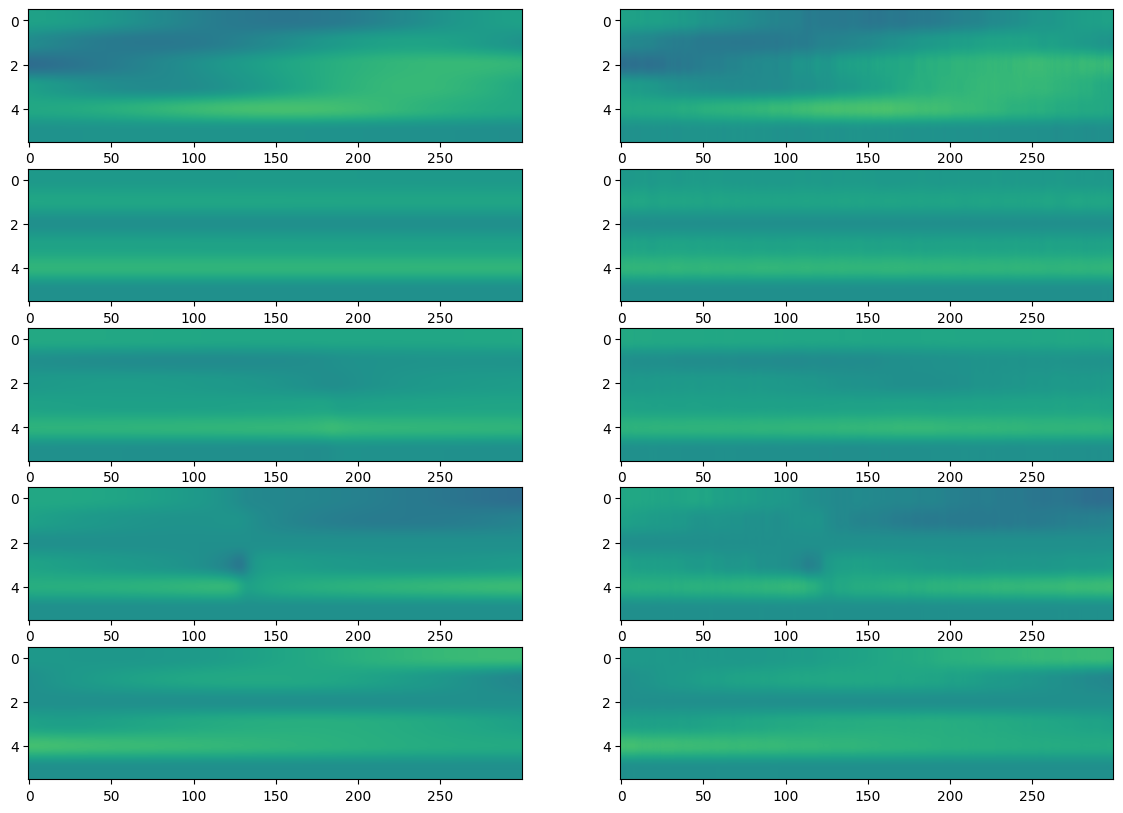

In [19]:
tsgm.utils.visualize_original_and_reconst_ts(scaled_data, x_decoded, num=5)

## Generate

In [20]:
# generation = vae.generate(int(data.shape[0]*0.01))
generation = vae.generate(100)
generation.shape

TensorShape([100, 300, 6])

In [21]:
generated_data_path = os.path.join(experiment_folder, 'generated_data.npy')
print(generated_data_path)

../experiments/experiment 3/generated_data.npy


In [22]:
inverted_generation = scaler.inverse_transform(generation)
np.save(generated_data_path, inverted_generation)
inverted_generation.shape

TensorShape([100, 300, 6])

In [25]:
# generation = np.load(generated_data_path)

# Analysis

## Visualization

In [25]:
if inverted_generation.shape[2] == 7:
    inverted_generation = inverted_generation[:,:,1:]
    inverted_generation.shape

display_generation = np.transpose(inverted_generation, (0, 2, 1))
display_generation.shape

(100, 6, 300)

In [26]:
static_all_orbit_path = os.path.join(experiment_folder, 'all_generated_data.png')
static_some_orbit_path = os.path.join(experiment_folder, 'some_generated_data.png')

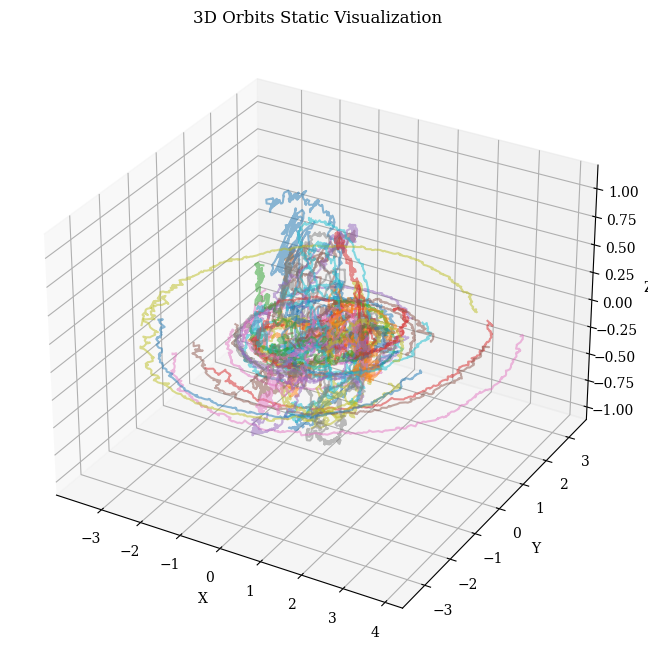

In [27]:
visualize_static_orbits(data= display_generation, show_legend=False, save_path=static_all_orbit_path)

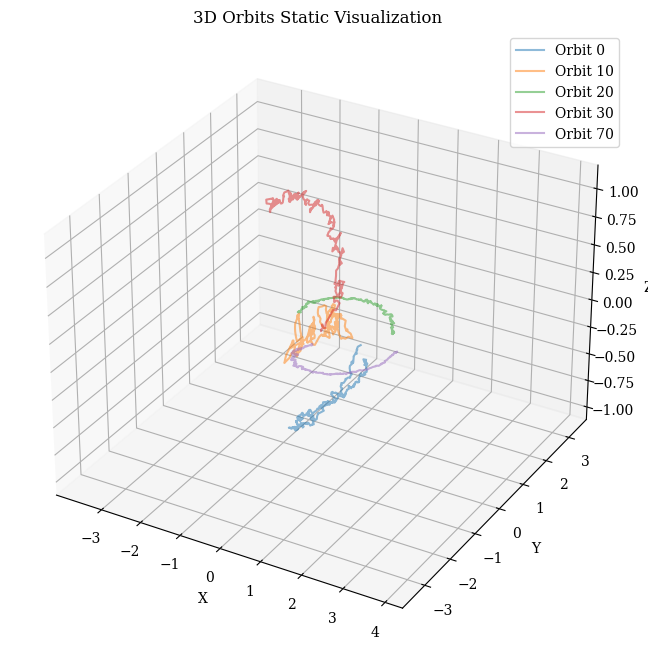

In [28]:
visualize_static_orbits(data= display_generation, orbit_indices=[0,10,20,30,70], save_path=static_some_orbit_path)

In [29]:
dynamic_orbits_path = os.path.join(experiment_folder, 'generated_orbits.html')
export_dynamic_orbits_html(data=display_generation, filename=dynamic_orbits_path)

Visualization saved to ../experiments/experiment 3/generated_orbits.html


## Coverage

In [30]:
data.shape

(95005, 6, 300)

In [31]:
inverted_ordered_generation = np.transpose(inverted_generation, (0, 2, 1))
inverted_ordered_generation.shape

(100, 6, 300)

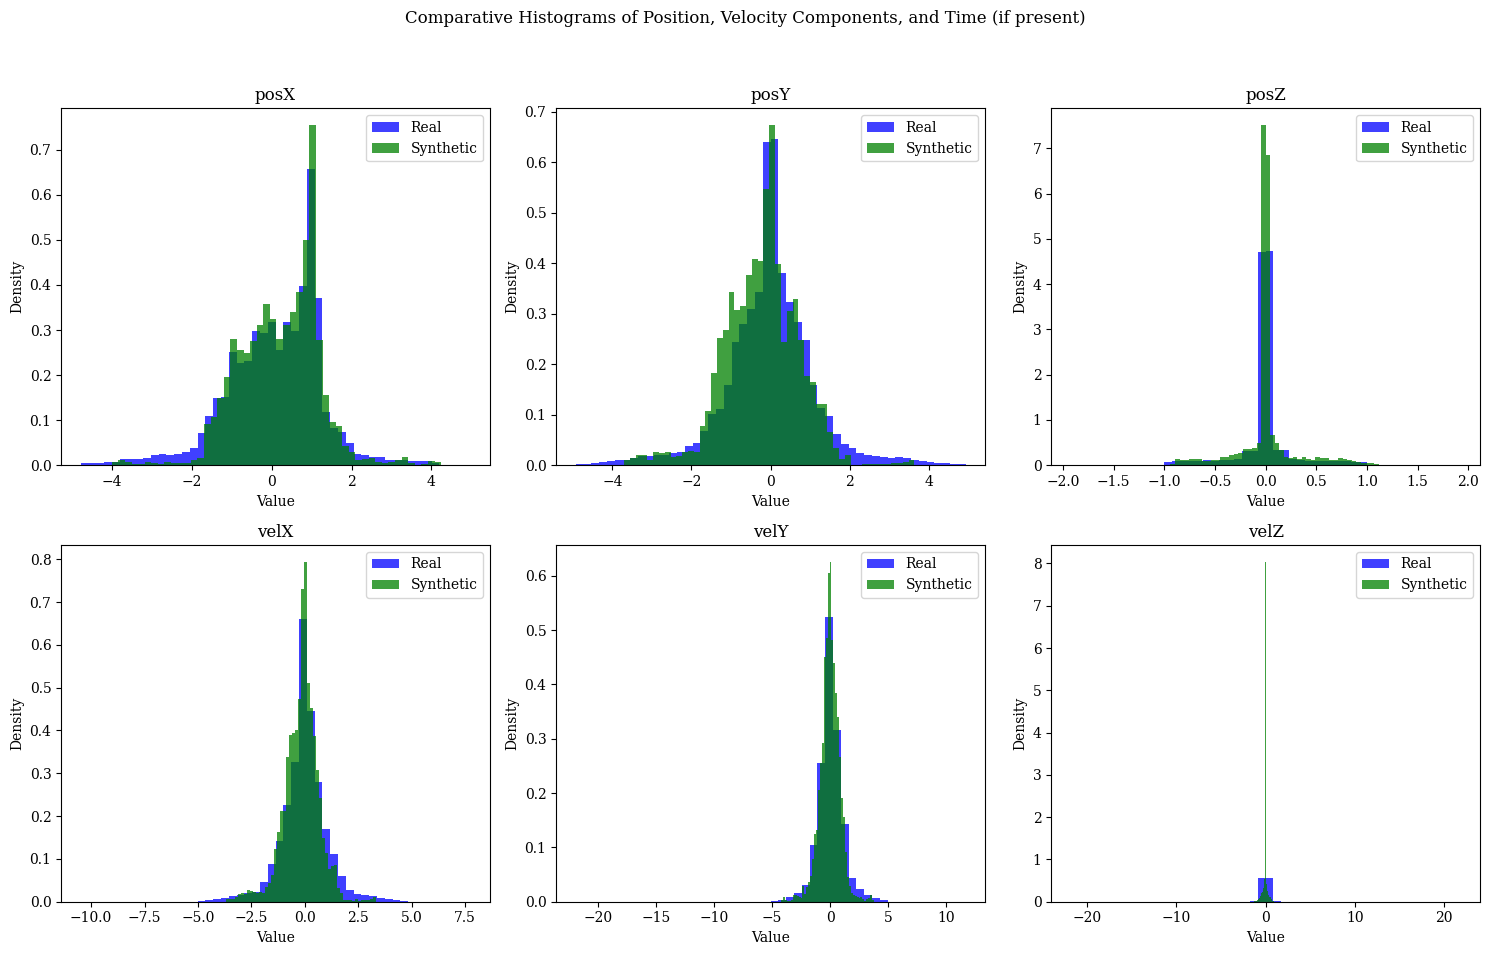

In [32]:
plot_histograms_comparison(data1=data, data2=inverted_ordered_generation, label1='Real', label2='Synthetic', normalize=True)

## Pheasibility

In [33]:
from orbit_generation.constants import EM_MU

Cumulative position error for selected orbits: 813.849285125475
Average position error per time step: 2.7219039636303513


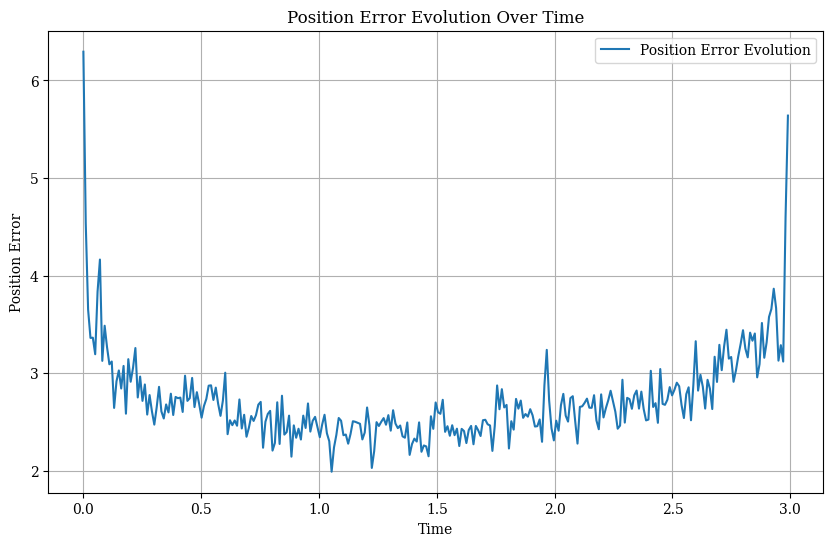

Cumulative velocity error for selected orbits: 1849.941609825726
Average velocity error per time step: 6.187095685035873


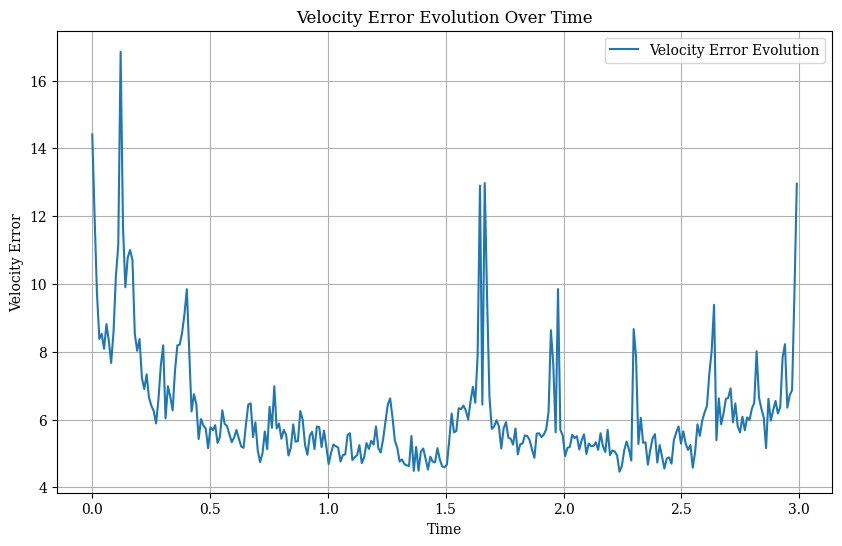

Cumulative energy error for selected orbits: 22894.734050203104
Average energy error per time step: 76.57101689031138


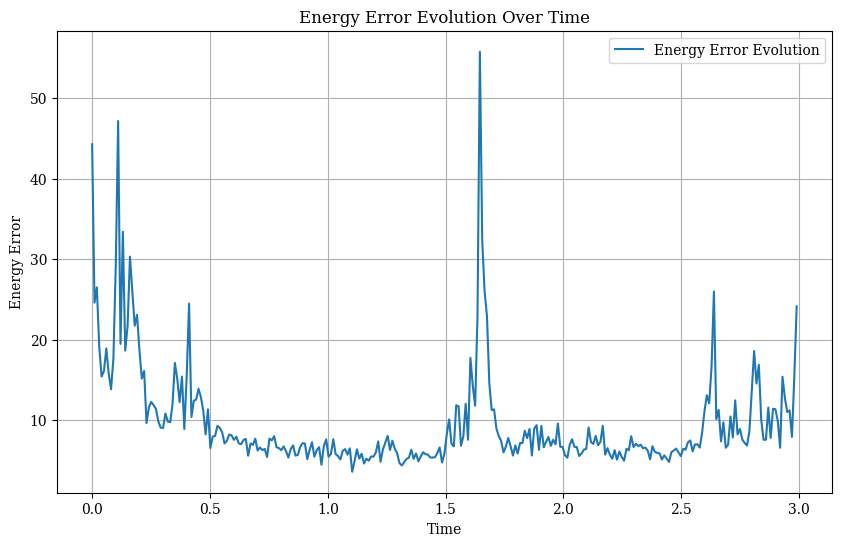

In [34]:
metrics = {} ## add model metrics
errors = calculate_errors(inverted_ordered_generation,EM_MU,time_step=0.01)

## Latent Visualization

In [35]:
np.random.seed(42)

# Randomly choose indices
random_indices = np.random.choice(data.shape[0], size=params['num_samples'], replace=False)

# Select the samples
sampled_data = scaled_data[random_indices]
sampled_labels = labels[random_indices]

sampled_data.shape

(1000, 300, 6)

In [36]:
latent_representations_path = os.path.join(experiment_folder, 'latent_representations.npy')
sampled_latent_representations_path = os.path.join(experiment_folder, 'sampled_latent_representations.npy')

In [37]:
latent_mean, latent_deviation, latent_epsilon = vae.encoder(sampled_data)
sampled_latent_representations = latent_mean.numpy()
sampled_latent_representations.shape

(1000, 32)

In [38]:
latent_mean, latent_deviation, latent_epsilon = vae.encoder(scaled_data)
latent_representations = latent_mean.numpy()
latent_representations.shape

2024-06-10 11:49:29.788436: W tensorflow/core/common_runtime/bfc_allocator.cc:479] Allocator (GPU_0_bfc) ran out of memory trying to allocate 6.79GiB (rounded to 7296384000)requested by op Conv2D
If the cause is memory fragmentation maybe the environment variable 'TF_GPU_ALLOCATOR=cuda_malloc_async' will improve the situation. 
Current allocation summary follows.
Current allocation summary follows.
2024-06-10 11:49:29.788558: I tensorflow/core/common_runtime/bfc_allocator.cc:1027] BFCAllocator dump for GPU_0_bfc
2024-06-10 11:49:29.788593: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (256): 	Total Chunks: 125, Chunks in use: 125. 31.2KiB allocated for chunks. 31.2KiB in use in bin. 11.0KiB client-requested in use in bin.
2024-06-10 11:49:29.788636: I tensorflow/core/common_runtime/bfc_allocator.cc:1034] Bin (512): 	Total Chunks: 1, Chunks in use: 1. 512B allocated for chunks. 512B in use in bin. 484B client-requested in use in bin.
2024-06-10 11:49:29.788658: I tensorflo

ResourceExhaustedError: Exception encountered when calling layer "conv1d" (type Conv1D).

OOM when allocating tensor with shape[95005,64,1,300] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc [Op:Conv2D]

Call arguments received by layer "conv1d" (type Conv1D):
  • inputs=tf.Tensor(shape=(95005, 300, 6), dtype=float32)

In [39]:
np.save(latent_representations_path, latent_representations)
np.save(sampled_latent_representations_path, sampled_latent_representations)

NameError: name 'latent_representations' is not defined

In [44]:
latent_space_path = os.path.join(experiment_folder, 'dimensionality_reduction_latent_space')
combined_latent_space_path = os.path.join(experiment_folder, 'combined_dimensionality_reduction_latent_space')

try different labels

Saved plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_PCA.png


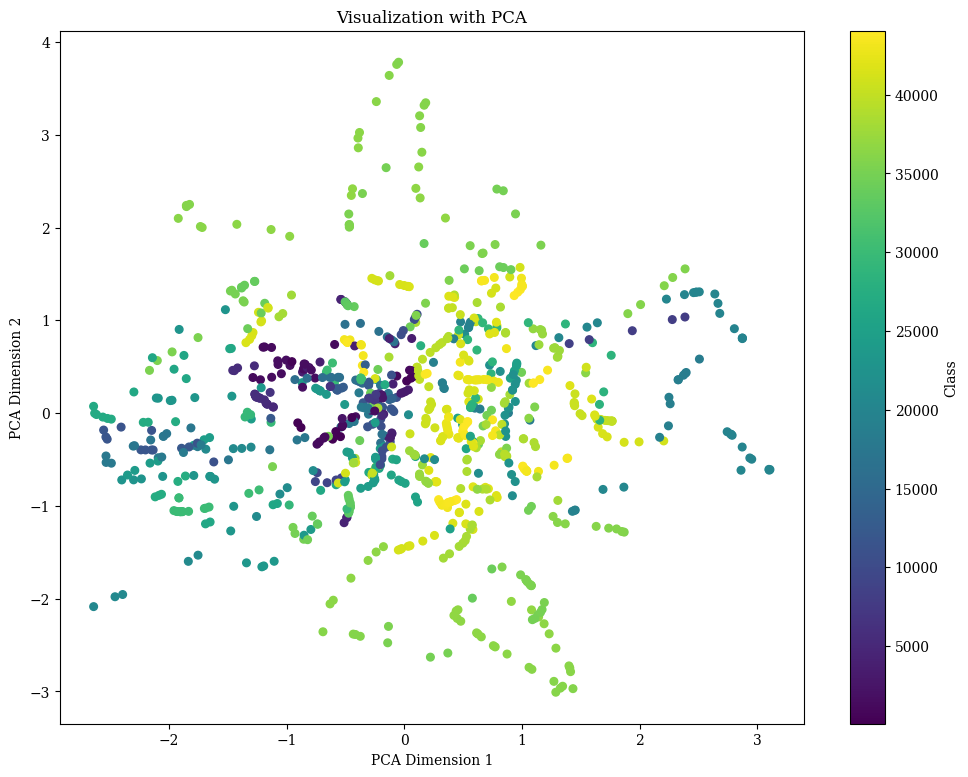

Saved plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_t-SNE.png


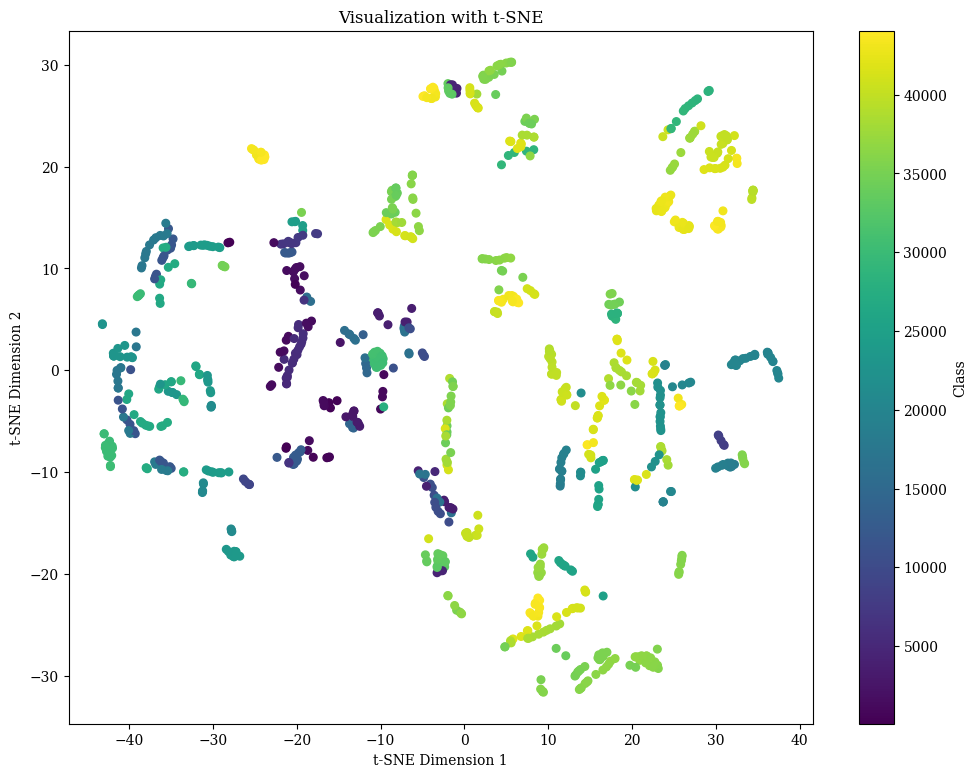

Saved plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_UMAP.png


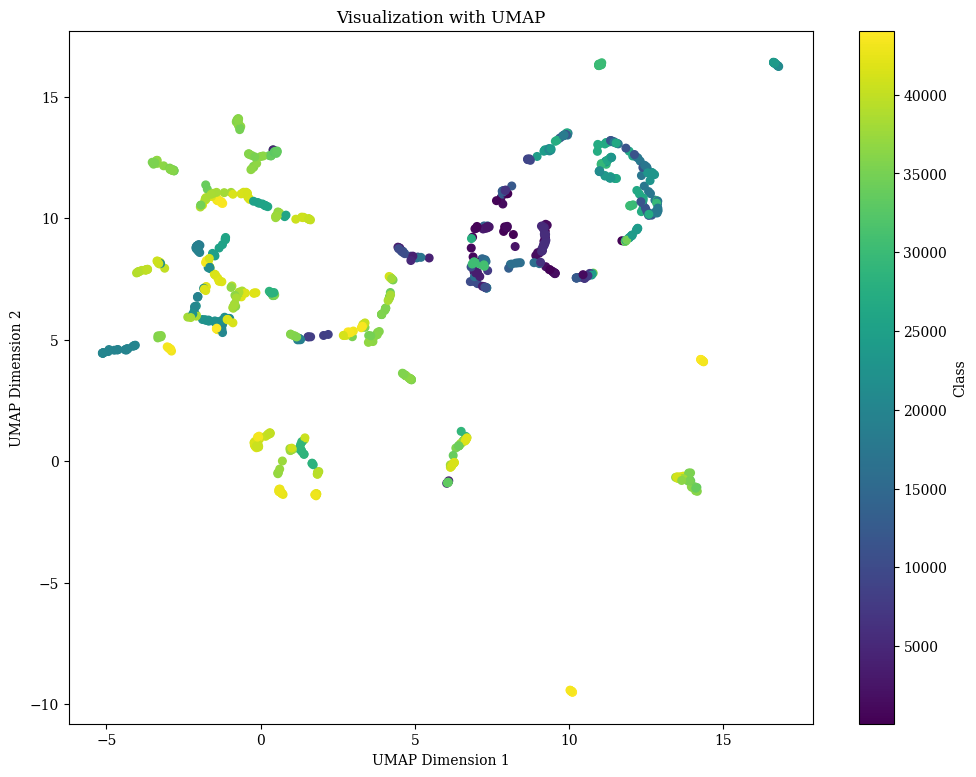

Saved plot to ../experiments/experiment 3/dimensionality_reduction_latent_space_LDA.png


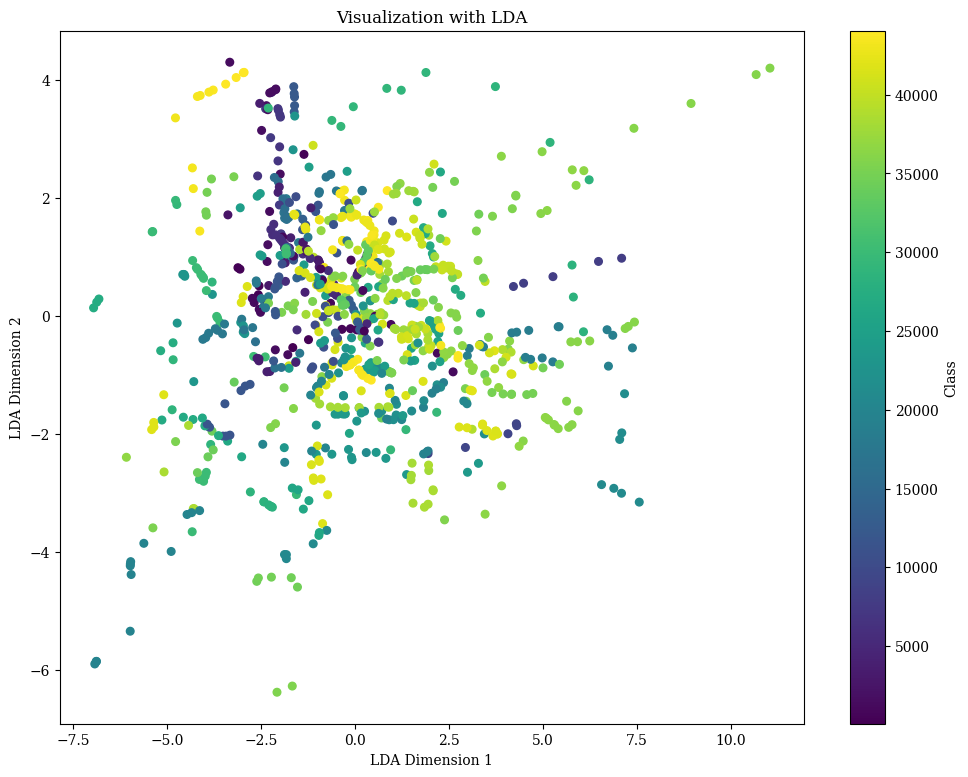

In [46]:

plot_latent_space(sampled_latent_representations, sampled_labels, techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path)

In [40]:
plot_latent_space(latent_representations, sampled_labels, techniques=['PCA','t-SNE','UMAP', 'LDA'], save_path=latent_space_path)

NameError: name 'latent_representations' is not defined

In [41]:
sampled_data.shape

(1000, 300, 6)

In [42]:
generation.shape

TensorShape([100, 300, 6])

35/35 [==============================] - 0s 6ms/step
Saved plot to ../experiments/experiment 3/combined_dimensionality_reduction_latent_space_PCA.png


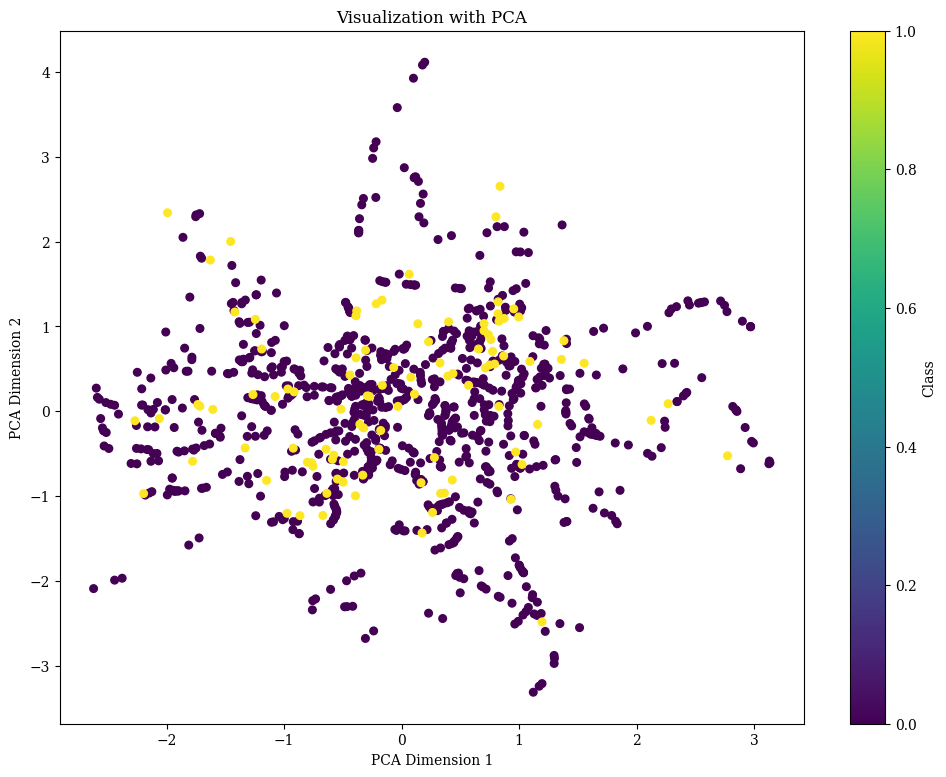

Saved plot to ../experiments/experiment 3/combined_dimensionality_reduction_latent_space_t-SNE.png


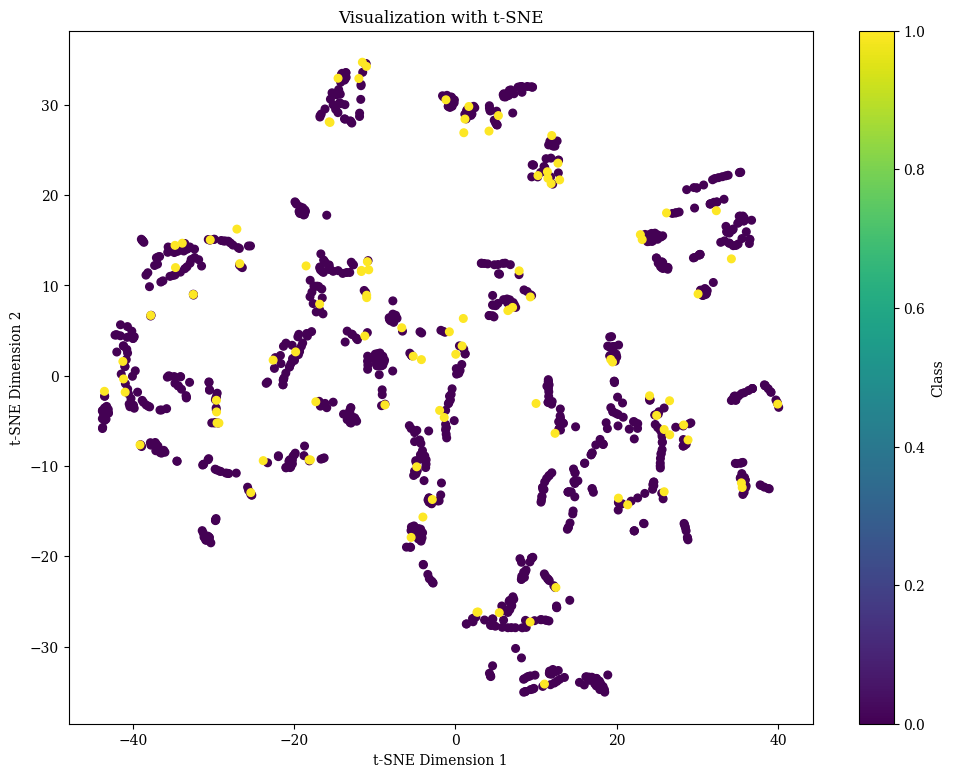

Saved plot to ../experiments/experiment 3/combined_dimensionality_reduction_latent_space_UMAP.png


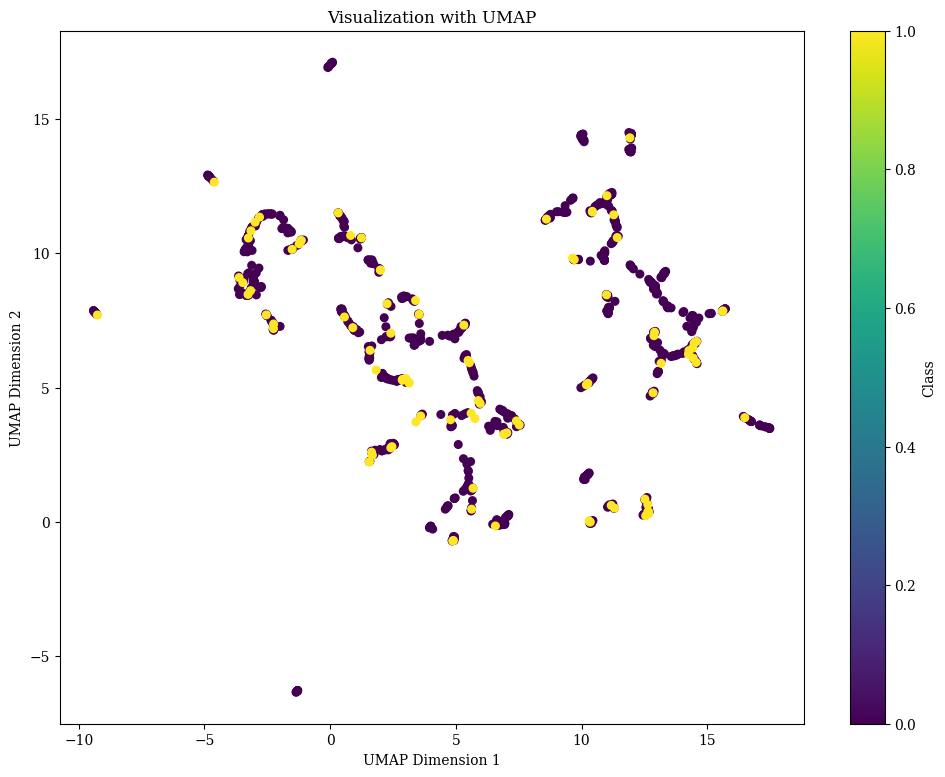

In [45]:
plot_combined_latent_space(sampled_data, generation, encoder, ['PCA','t-SNE','UMAP'], save_path=combined_latent_space_path)

In [47]:
wandb.finish()

epoch,▁▁▂▂▂▂▃▃▃▄▄▄▅▅▅▅▆▆▆▇▇▇▇██
kl_loss,█▅▄▃▂▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
loss,█▃▂▂▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
reconstruction_loss,█▂▂▁▂▁▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
epoch,24
kl_loss,8.51377
loss,12.98473
reconstruction_loss,4.47095
